In [83]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
from PIL import Image
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from transformers import BertModel, BertTokenizer

In [84]:
# Mount to Google Drive so images in Drive can be accessed by Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# Read CSV file that contains corresponding item data
data = pd.read_csv('/content/drive/MyDrive/depop_item_details_complete.csv')
data = data.drop(columns=['Image', 'Date', 'Location'])
data.head()

,Description,Price listed,Price sold,Size,Brand
0,🌫️ Vintage hot pink sweater 🌫️ ▫️ Stretchy hot...,US$20.00,US$11.00,M,Cache
1,🌫️ Wool pencil skirt 🌫️ ▫️ Grey wool fabric sh...,US$15.00,US$4.50,4,Ralph Lauren
2,🌫️ Green and Black corset🌫️ ▫️ Gorge iridescen...,US$14.00,US$7.00,30,Other
3,🌫️ Vintage denim mini skirt 🌫️ ▫️ Lighter weig...,US$20.00,US$6.00,6,Calvin Klein
4,🌫️ Wide leg y2k pants 🌫️ ▫️ Thick black fabric...,US$20.00,US$14.00,8,American Vintage


In [86]:
# Prices pulled from Depop are strings and have undesired 'US$', let's change them to floats for easier calculations
def pricing(price):
    """
    Reformat scraped Depop prices to floats.

    Parameters:
    price (string): Price string from Depop.

    Returns:
    price (float): Price as a float.
    """
    try:
      return float(price.replace('US$', ''))

    except ValueError:
      return price

# Apply pricing function
data['Price listed'] = data['Price listed'].apply(pricing)
data['Price sold'] = data['Price sold'].apply(pricing)

In [87]:
# Sizes pulled from Depop vary too greatly to be useful to NN, so we implement a simple sizing scheme
def sizing(size):
    """
    Find and replace numbered sizing (in womens clothing) and replace values with more discrete sizing scheme.

    Parameters:
    size (string): Raw size string from Depop.

    Returns:
    size (string): Size string converted in scheme.
    """
    try:
      # If size is number, it can be converted into a float, and therefore needs a category defined by the scheme below
      size = float(size)
      if size <= 4:
        return 'XS'

      elif size <= 8 or size == 26: # Note, the 26 is accounting for a pair of jeans in my particular dataset
        return 'S'

      elif size <= 12:
        return 'M'

      elif size <= 16 or size == 30: # Note, the 30 is accounting for a corset in my particular dataset
        return 'L'

      else:
        return 'XL'

    except ValueError:
      # If size isn't a number and contains 'US', it is a shoe
      # Handling this under scheme for now, but should potentially be changed to cater towards shoes (rather than clothing)
      if 'US ' in size:
        size = size.replace('US ', '')

        try:
          return sizing(float(size))

        except ValueError:
          return size

      else:
        return size

# Apply sizing function
data['Size'] = data['Size'].apply(sizing)

In [88]:
# Define transform function to convert image to tensor of proper dimensions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Initialize input_images array to store RGB matrices
input_images = []
indices = np.array(data.index)

# Load each RGB matrix and add to input_images array
for i in indices:
  rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")
  input_images.append(transform(rgb_matrix))

# Add Image column to data
data['Image'] = input_images

In [89]:
# Initialize pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize vocab_size for later use
vocab_size = bert_tokenizer.vocab_size

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [90]:
# Scale Price listed values to help neural network
scaler = StandardScaler()
data['Price listed'] = scaler.fit_transform(data['Price listed'].values.reshape(-1, 1))

# Perform one-hot encoding on Size and Brand columns together
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform both size and brand columns simultaneously
size_brand_encoded = encoder.fit_transform(data[['Size', 'Brand']])

# Create a DataFrame with the new one-hot encoded columns
encoded_columns = encoder.get_feature_names_out(['Size', 'Brand'])  # Get appropriate column names
df_encoded = pd.DataFrame(size_brand_encoded, columns=encoded_columns)

# Drop original Size and Brand columns from the original DataFrame
data = data.drop(columns=['Size', 'Brand'])

# Concatenate the one-hot encoded columns back to the original DataFrame
data = pd.concat([data.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)

# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=8)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=8)

# Verify dimensions of each dataset
print("Dimensions of train data: ", train_data.shape)
print("Dimensions of validation data: ", val_data.shape)
print("Dimensions of test data: ", test_data.shape)

Dimensions of train data:  (355, 165)
Dimensions of validation data:  (40, 165)
Dimensions of test data:  (99, 165)


In [91]:
# Custom collate function to handle batching of tokenized descriptions
def custom_collate_fn(batch):
    images = []
    input_ids = []
    attention_masks = []
    other_features = []
    labels = []

    for item in batch:
        images.append(item['image'])
        input_ids.append(item['input_ids'])
        attention_masks.append(item['attention_mask'])
        other_features.append(item['other_features'])
        labels.append(item['label'])

    images = torch.stack(images)
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    other_features = torch.stack(other_features)
    labels = torch.tensor(labels)

    return {
        'images': images,
        'input_ids': input_ids,
        'attention_masks': attention_masks,
        'other_features': other_features,
        'labels': labels
    }


# Dataset to return dictionary of each item's elements
class DepopDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Load image as a tensor
        image = row['Image'].clone().detach()

        # Tokenize description using BertTokenizer
        description = bert_tokenizer(
            row['Description'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        input_ids = description['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = description['attention_mask'].squeeze(0)  # Remove batch dimension

        # Extract price listed as 1D tensor
        price = torch.tensor(row['Price listed'], dtype=torch.float32).view(1)

        # Extract all columns that match the pattern for one-hot encoded size and brand
        size_columns = [col for col in self.data.columns if col.startswith('Size_')]
        brand_columns = [col for col in self.data.columns if col.startswith('Brand_')]

        # Convert size and brand columns to tensors
        size = torch.tensor(row[size_columns].astype('float32').values, dtype=torch.float32).view(-1)
        brand = torch.tensor(row[brand_columns].astype('float32').values, dtype=torch.float32).view(-1)

        # Combine price with one-hot encoded size and brand
        other_features = torch.cat((price, size, brand), dim=0)

        # Extract label (target price for regression)
        label = torch.tensor(row['Price sold'], dtype=torch.float32).view(1)

        # Return all item details as dictionary
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'other_features': other_features,
            'label': label
        }

In [92]:
# Create DataLoaders for train, validation, and test sets
train_dataset = DepopDataset(train_data)
val_dataset = DepopDataset(val_data)
test_dataset = DepopDataset(test_data)

batch_size = 10  # Adjust as needed

# Instantiate DataLoader with custom collate function
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn) # We only care about shuffling the training dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [93]:
# We'll now initialize the DescriptionTransformer to process descriptions of items
class DescriptionTransformer(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_encoder_layers=4):
        super(DescriptionTransformer, self).__init__()

        # Load BERT model (you can also unfreeze some layers for fine-tuning)
        self.bert_model = BertModel.from_pretrained(bert_model_name)

        # Transformer encoder layers on top of BERT
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True),  # BERT's hidden size is 768
            num_layers=num_encoder_layers
        )

        # Fully connected layers
        self.fc_1 = nn.Linear(768, 256)
        self.fc_2 = nn.Linear(256, 128)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)  # 30% dropout

        # Batch normalization
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)

    def forward(self, input_ids, attention_mask):
        # BERT embeddings
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        token_embeddings = outputs.last_hidden_state  # Shape: [batch_size, seq_len, 768]

        # Transformer encoding layers
        x = self.transformer_encoder(token_embeddings)

        # Pooling (weighted average of token embeddings)
        attention_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size())  # Expand mask shape
        x = (x * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)  # Weighted average across tokens

        # Fully connected layer with dropout and batch normalization
        x = self.fc_1(x)
        x = self.batchnorm1(x)  # Apply batch normalization
        x = self.dropout(x)

        x = self.fc_2(x)
        x = self.batchnorm2(x)  # Apply batch normalization
        x = self.dropout(x)

        return x


In [94]:
# The meat of this project: define CNN to handle images
class DepopPriceCNN(nn.Module):
    def __init__(self):
        super(DepopPriceCNN, self).__init__()

        # CNN for image input (assuming 3-channel RGB input, 128x128 images)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_image_1 = nn.Sequential(
            nn.Linear(16 * 32 * 32, 256),   # Input size matches flattened image
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_image_2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        self.description_transformer = DescriptionTransformer()


        # Fully connected layers for the non-image data (price, size, brand)
        self.fc_other_1 = nn.Sequential(
            nn.Linear(1 + 15 + 146, 128),  # Sizes and brands one-hot encoded, price as float
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_other_2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_other_3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Final combined layers
        self.fc_combined_1 = nn.Sequential(
            nn.Linear(128 + 128 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_combined_2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_combined_3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_combined_4 = nn.Linear(32, 1)  # Output layer for price prediction

    def forward(self, image, input_ids, other_features, attention_mask):
        # CNN for image
        x_image = self.conv1(image)
        x_image = self.conv2(x_image)
        x_image = self.conv3(x_image)
        x_image = x_image.view(x_image.size(0), -1)  # Flatten image features
        x_image = self.fc_image_1(x_image)
        x_image = self.fc_image_2(x_image)

        # Extract attention_mask
        x_description = self.description_transformer(input_ids, attention_mask)  # Pass both to the transformer

        # Fully connected for other numerical inputs (price, size, brand)
        x_other = self.fc_other_1(other_features)
        x_other = self.fc_other_2(x_other)
        x_other = self.fc_other_3(x_other)

        # Combine all inputs
        x_combined = torch.cat([x_image, x_description, x_other], dim=1)

        # Final layers
        x_combined = self.fc_combined_1(x_combined)
        x_combined = self.fc_combined_2(x_combined)
        x_combined = self.fc_combined_3(x_combined)
        output = self.fc_combined_4(x_combined)

        return output

In [95]:
# Initialize Training Loss and Validation Accuracy list
train_loss_list = []
avg_train_loss_list = []
val_loss_list = []

# Lists to store MAE values for each epoch
train_accuracy_list = []
val_accuracy_list = []

def calculate_mape(predictions, actuals):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    actuals (tensor): Actual prices (ground truth).
    predictions (tensor): Predicted prices by the model.

    Returns:
    mape (float): MAPE value as a percentage.
    """
    epsilon = 1e-12  # Small value to prevent division by zero
    percentage_error = torch.abs((actuals - predictions) / (actuals + epsilon)) * 100
    mape = percentage_error.mean().item()  # Take the average over all predictions
    return mape

In [96]:
# Initialize the model, loss function, and optimizer
model = DepopPriceCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
num_epochs = 17

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_mape = 0.0

    for batch in train_loader:
        # Split the batch into its components
        image = batch['images']  # Extract image tensor
        input_ids = batch['input_ids']  # Extract tokenized description (input_ids)
        attention_mask = batch['attention_masks']  # Extract attention masks
        other_features = batch['other_features']  # Extract other features (e.g., price, size, brand)
        labels = batch['labels']  # Extract label (target price)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(image, input_ids, other_features, attention_mask)
        loss = criterion(outputs, labels.view(-1, 1))
        train_loss_list.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate MAPE for the batch
        batch_mape = calculate_mape(outputs, labels.view(-1, 1))
        running_mape += batch_mape

    avg_train_loss = running_loss / len(train_loader)
    avg_train_mape = running_mape / len(train_loader)
    train_accuracy_list.append(avg_train_mape)
    avg_train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training MAPE: {avg_train_mape:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_running_mape = 0.0

    with torch.no_grad():
        for batch in val_loader:
            val_image = batch['images']
            val_input_ids = batch['input_ids']
            val_attention_mask = batch['attention_masks']
            val_other_features = batch['other_features']
            val_labels = batch['labels']

            val_outputs = model(val_image, val_input_ids, val_other_features, val_attention_mask)
            val_loss_item = criterion(val_outputs, val_labels.view(-1, 1)).item()
            val_loss += val_loss_item

            # Calculate MAPE for validation batch
            val_mape_batch = calculate_mape(val_outputs, val_labels.view(-1, 1))
            val_running_mape += val_mape_batch

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mape = val_running_mape / len(val_loader)
    val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(avg_val_mape)

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation MAPE: {avg_val_mape:.4f}')


Epoch [1/17], Training Loss: 294.8150, Training MAPE: 98.0180
Epoch [1/17], Validation Loss: 331.1740, Validation MAPE: 94.5960
Epoch [2/17], Training Loss: 235.1673, Training MAPE: 77.7637
Epoch [2/17], Validation Loss: 183.8660, Validation MAPE: 54.3133
Epoch [3/17], Training Loss: 121.5208, Training MAPE: 74.7320
Epoch [3/17], Validation Loss: 83.4180, Validation MAPE: 49.9363
Epoch [4/17], Training Loss: 106.6541, Training MAPE: 85.4001
Epoch [4/17], Validation Loss: 81.7344, Validation MAPE: 48.7982
Epoch [5/17], Training Loss: 105.4878, Training MAPE: 78.9022
Epoch [5/17], Validation Loss: 78.7258, Validation MAPE: 49.6141
Epoch [6/17], Training Loss: 103.8236, Training MAPE: 75.0850
Epoch [6/17], Validation Loss: 75.5752, Validation MAPE: 52.3204
Epoch [7/17], Training Loss: 99.3998, Training MAPE: 78.5421
Epoch [7/17], Validation Loss: 79.0984, Validation MAPE: 49.4859
Epoch [8/17], Training Loss: 100.6568, Training MAPE: 79.7459
Epoch [8/17], Validation Loss: 87.7571, Validati

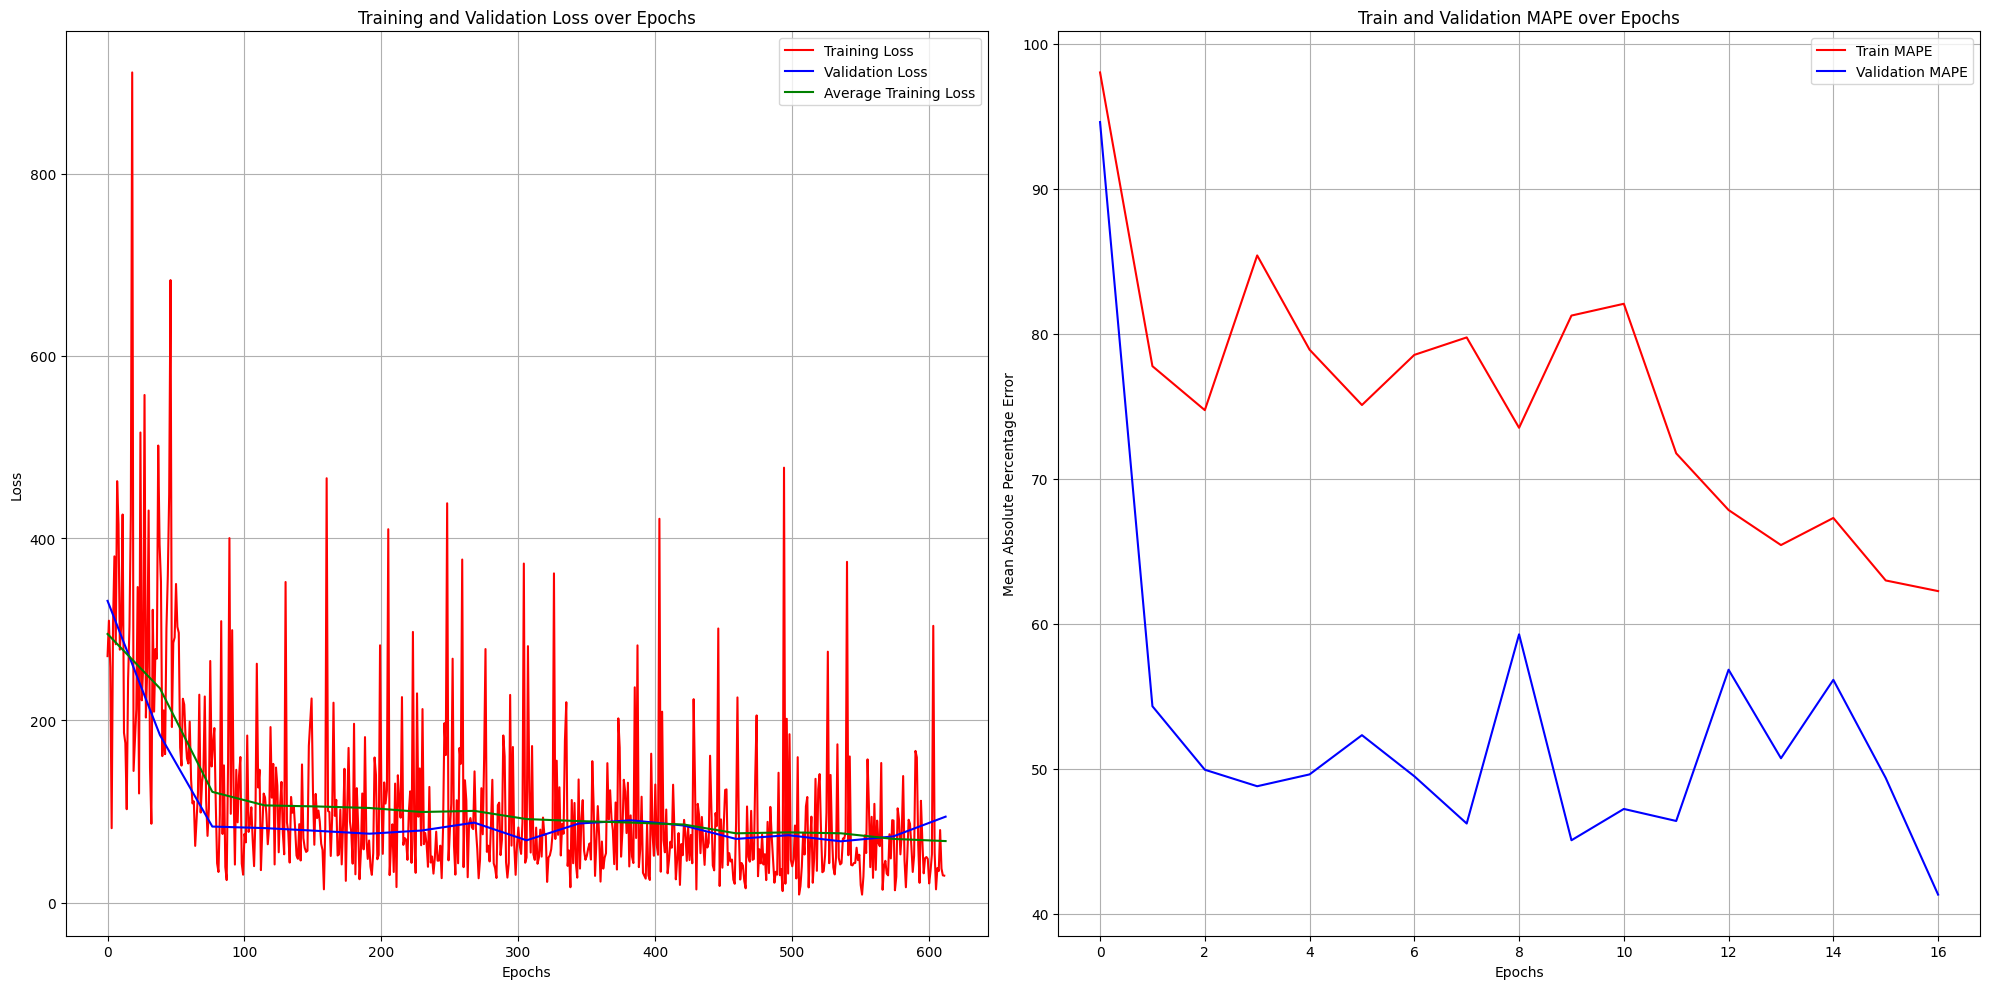

In [97]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the training and validation loss
ax1.plot(train_loss_list, color='red', label='Training Loss')
ax1.plot(np.linspace(0, len(train_loss_list), len(val_loss_list)), val_loss_list, color='blue', label='Validation Loss')
ax1.plot(np.linspace(0, len(train_loss_list), len(avg_train_loss_list)), avg_train_loss_list, color='green', label='Average Training Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title('Training and Validation Loss over Epochs')
ax1.legend()
ax1.grid(True)

# Plot the training and validation MAPE
ax2.plot(train_accuracy_list, label='Train MAPE', color='red')
ax2.plot(val_accuracy_list, label='Validation MAPE', color='blue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Absolute Percentage Error')
ax2.set_title('Train and Validation MAPE over Epochs')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [98]:
# Evaluation on the test set
model.eval()
test_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for test_batch in test_loader:
        test_image = test_batch['images']
        test_input_ids = test_batch['input_ids']
        test_attention_mask = test_batch['attention_masks']
        test_other_features = test_batch['other_features']
        test_label = test_batch['labels']

        test_outputs = model(test_image, test_input_ids, test_other_features, test_attention_mask)
        test_loss += criterion(test_outputs, test_label.view(-1, 1)).item()

        predictions.extend(test_outputs.view(-1).cpu().numpy())
        actuals.extend(test_label.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 74.8135


In [99]:
calculate_mape(torch.tensor(predictions),torch.tensor(actuals))

41.109317779541016

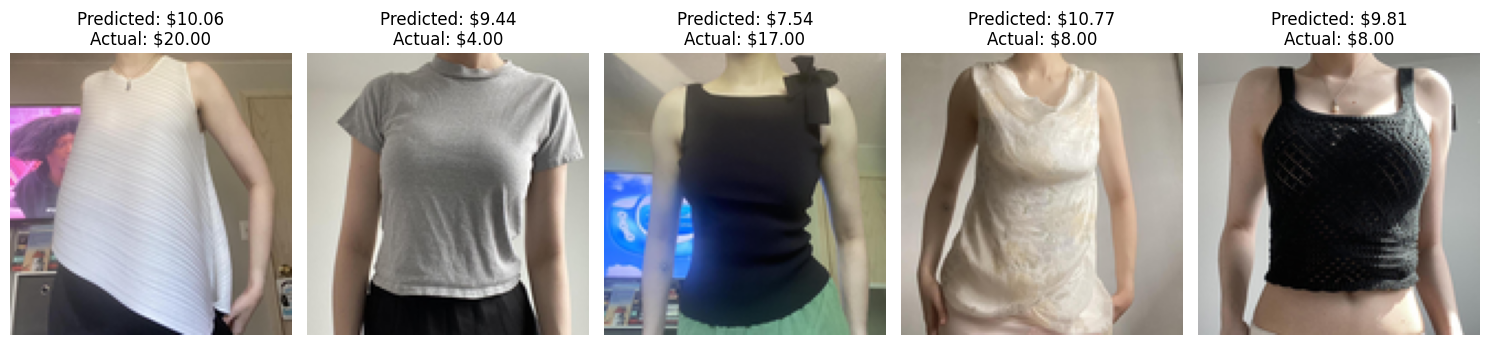

In [100]:
# Now we'll visualize model performance
num_samples = 5  # Adjust based on how many you want to see
real_values = actuals[-num_samples: ]
predicted_values = predictions[-num_samples: ]

# Define the mean and std values used for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to reverse normalization
def reverse_normalize(tensor):
    return tensor * std[:, None, None] + mean[:, None, None]

plt.figure(figsize=(15, 10))

for i  in range(1, num_samples + 1):
    image_tensor = test_batch['images'][-num_samples + i - 1]  # Extract the features for the idx
    image = image_tensor.view(3, 128, 128)  # Reshape to (C, H, W)
    image = reverse_normalize(image)  # Apply reverse normalization
    actual_price = real_values[i - 1].item()  # Ensure it's a scalar
    predicted_price = predicted_values[i - 1].item()  # Ensure it's a scalar

    # Transpose to HxWxC for visualization
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for plt.imshow

    # Plotting
    plt.subplot(2, num_samples, i)
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide axes
    plt.title(f'Predicted: ${predicted_price:.2f}\nActual: ${actual_price:.2f}')  # Show prices

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()